In [9]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [10]:
def benchmark(X, Y):
    return -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)


In [11]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 5

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [12]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [13]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 5, 5)
Y = np.random.uniform(-5, 5, 5)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [14]:
df

,x,y,z
0,-0.829780,-4.076614,-284.253932
1,2.203245,-3.137398,-111.669530
2,-4.998856,-1.544393,-247.301416
3,-1.976674,-1.032325,-128.722651
4,-3.532441,0.388167,-111.174208


In [15]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [16]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.32432971 -3.06924425]


In [17]:
df_sim = df.copy()

df_sim

,x,y,z,a,b,sim_z,diff
0,-0.829780,-4.076614,-284.253932,4.32433,-3.069244,-282.256649,-1.997283
1,2.203245,-3.137398,-111.669530,4.32433,-3.069244,-113.354470,1.684940
2,-4.998856,-1.544393,-247.301416,4.32433,-3.069244,-242.011988,-5.289428
3,-1.976674,-1.032325,-128.722651,4.32433,-3.069244,-126.540507,-2.182144
4,-3.532441,0.388167,-111.174208,4.32433,-3.069244,-107.847611,-3.326597


In [18]:
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-4.076614,-284.253932,4.32433,-3.069244,-282.256649,-1.997283
1,2.203245,-3.137398,-111.669530,4.32433,-3.069244,-113.354470,1.684940
2,-4.998856,-1.544393,-247.301416,4.32433,-3.069244,-242.011988,-5.289428
3,-1.976674,-1.032325,-128.722651,4.32433,-3.069244,-126.540507,-2.182144
4,-3.532441,0.388167,-111.174208,4.32433,-3.069244,-107.847611,-3.326597


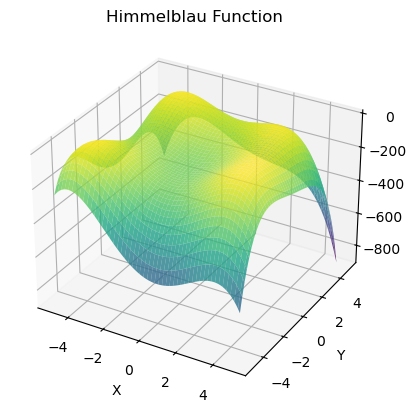

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Himmelblau Function')

# Show the plot
plt.show()

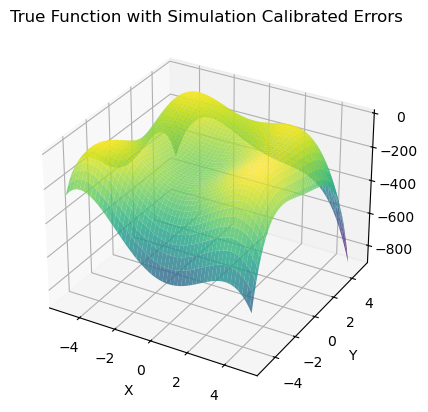

In [20]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [21]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [22]:
df_new = pd.DataFrame

In [23]:
def perform_iteration(df, df2):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3, shuffle=True, random_state=0)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-5, 5, 100)
    x2_range = np.linspace(-5, 5, 100)
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    x_grid_scaled = scaler_x.transform(x_grid)

    # Perform MC Dropout predictions for entire meshgrid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid_scaled)

    # Define range for inputs
    bounds = np.array([[-5, 5], [-5, 5]])

    from scipy.spatial.distance import cdist

    def select_points_with_diversity(candidate_points, uci_values, min_distance, num_points):
        sorted_indices = np.argsort(uci_values)[::-1]
        candidate_points = candidate_points[sorted_indices]
        uci_values = uci_values[sorted_indices]
        
        # Initialize selected points
        selected_points = []
        selected_uci = []
        
        for i, point in enumerate(candidate_points):
            if len(selected_points) == 0:
                # Always select the first point
                selected_points.append(point)
                selected_uci.append(uci_values[i])
            else:
                # Check distances to all previously selected points
                distances = cdist([point], selected_points)
                if np.all(distances > min_distance):
                    selected_points.append(point)
                    selected_uci.append(uci_values[i])
            
            # Stop when required number of points is selected
            if len(selected_points) == num_points:
                break
        
        return np.array(selected_points), np.array(selected_uci)

    # Example Usage
    num_candidates = 100
    num_top_points = 10
    min_distance = 0.5  # Minimum distance between points

    # Generate candidate points and their UCI
    sampler = qmc.LatinHypercube(d=2)
    lhs_sample = sampler.random(n=num_candidates)
    candidate_points = qmc.scale(lhs_sample, bounds[:, 0], bounds[:, 1])
    lhs_mean, lhs_std = mc_dropout_predictions(best_model, candidate_points)
    uci_values = lhs_mean + 1.96 * lhs_std

    # Select diverse points with high UCI
    selected_points, selected_uci = select_points_with_diversity(candidate_points, uci_values, min_distance, num_top_points)

    # Create DataFrame for results
    selected_points_df = pd.DataFrame(selected_points, columns=['x', 'y'])
    df2 = selected_points_df
    selected_points_df['z'] = selected_uci

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot next candidate points
    ax.scatter(selected_points_df['x'], selected_points_df['y'], selected_points_df['z'], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    # Add validated data points to original data frame
    df2["z"] = benchmark(df2['x'], df2['y']) + ran_err(10, 0.05)
    df2["a"] = bo.x_opt[0]
    df2["b"] = bo.x_opt[1]
    df2["sim_z"] = sim_eval(df2["x"], df2["y"], df2["a"], df2["b"])
    df2["diff"] = df2["z"] - df2["sim_z"]

    df = pd.concat([df, df2], axis=0, ignore_index=True)

    # Select 5 candidate points for next physical observation
    df2_sorted = df2.sort_values(by='sim_z', ascending=False)
    df2 = df2_sorted.head(5)

    return df, df2


Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.1
dropout_rate: 0.5
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step - loss: 35770.1289
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 30078.6914
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 13083.7773
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 20980.0254
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 15068.0205
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4742.3062
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10193.6982
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8428.7363
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8473.7412
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2314.8411
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3910.1401
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2120.5417
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss:

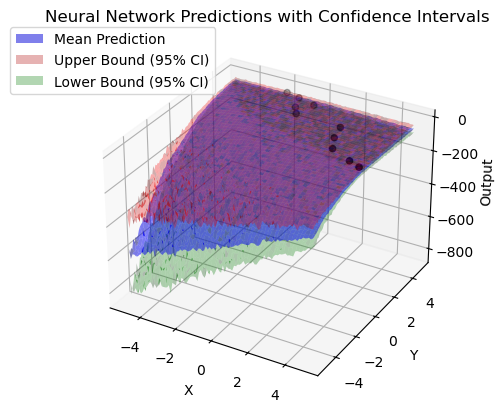

          x         y          z        a         b      sim_z      diff
9  2.355173  1.820000 -15.025293  4.32433 -3.069244 -14.775508 -0.249785
7  2.810329  0.814602 -17.632360  4.32433 -3.069244 -17.502018 -0.130342
4  2.116961  2.880274 -24.896646  4.32433 -3.069244 -24.655596 -0.241050
2  4.078774  0.125352 -41.745840  4.32433 -3.069244 -41.485970 -0.259871
3 -0.417517  3.061194 -64.065361  4.32433 -3.069244 -64.181085  0.115724
           x         y           z        a         b       sim_z      diff
0  -0.829780 -4.076614 -284.253932  4.32433 -3.069244 -282.256649 -1.997283
1   2.203245 -3.137398 -111.669530  4.32433 -3.069244 -113.354470  1.684940
2  -4.998856 -1.544393 -247.301416  4.32433 -3.069244 -242.011988 -5.289428
3  -1.976674 -1.032325 -128.722651  4.32433 -3.069244 -126.540507 -2.182144
4  -3.532441  0.388167 -111.174208  4.32433 -3.069244 -107.847611 -3.326597
5  -1.100744  4.556836 -187.786213  4.32433 -3.069244 -187.997842  0.211629
6   4.746336 -0.191240 -133.44

In [24]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Best hyperparameters:
num_layers: 7
num_units: 199
learning_rate: 0.0021252073916553185
dropout_rate: 0.20718429411318445
batch_size: 82
epochs: 144
Epoch 1/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 21369.8438
Epoch 2/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 21325.0039
Epoch 3/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 21231.7773
Epoch 4/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 21039.6367
Epoch 5/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 20484.4883
Epoch 6/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19704.5977
Epoch 7/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 18141.9941
Epoch 8/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 16067.7822
Epoch 9/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 10243.9521
Epoch 10/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6029.5146
Epoch 11/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3825.1194
Epoch 12/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8152.1387
Epoch 13/144
1/1 ━━━━━━━━

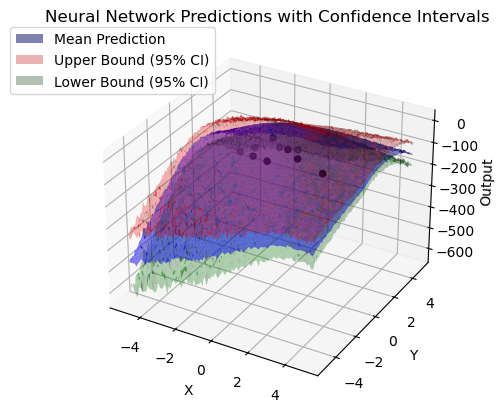

In [25]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 5
num_units: 200
learning_rate: 0.0020823882567041164
dropout_rate: 0.5
batch_size: 20
epochs: 96
Epoch 1/96
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 19343.6445
Epoch 2/96
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19596.8652 
Epoch 3/96
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19566.3320 
Epoch 4/96
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19370.9238 
Epoch 5/96
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19292.1016 
Epoch 6/96
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18365.1211 
Epoch 7/96
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17756.3535 
Epoch 8/96
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14177.6064 
Epoch 9/96
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8693.2832 
Epoch 10/96
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6711.3301 
Epoch 11/96
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6408.8906 
Epoch 12/96
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9726.5527  
Epoch 13/96
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

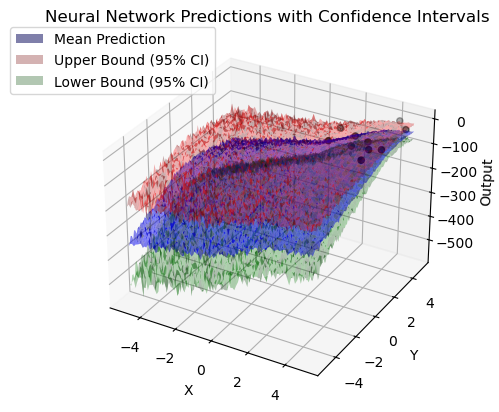

In [26]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 4
num_units: 50
learning_rate: 0.005210426737068645
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 36718.3750
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 36649.1758
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 36570.1758
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 36469.3047
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 36339.3750
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 36168.9648
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 35946.6680
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 35658.6719
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 35286.5820
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 34808.8047
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 34198.0195
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 33424.1367
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

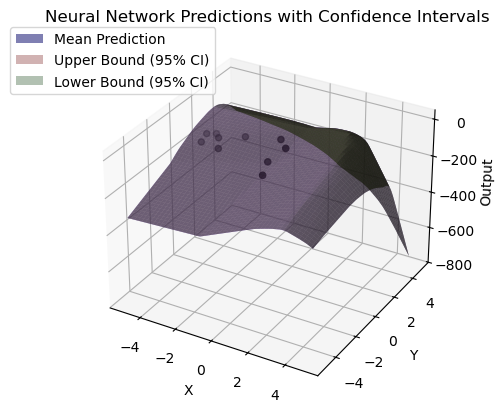

In [27]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 3
num_units: 50
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 33639.1797
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19460.8223 
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21170.0625 
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26838.1836 
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22274.0449 
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12138.6465 
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13719.7539 
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8879.0771 
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8734.6279 
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8997.5332  
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6243.2671 
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4148.8511 
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31

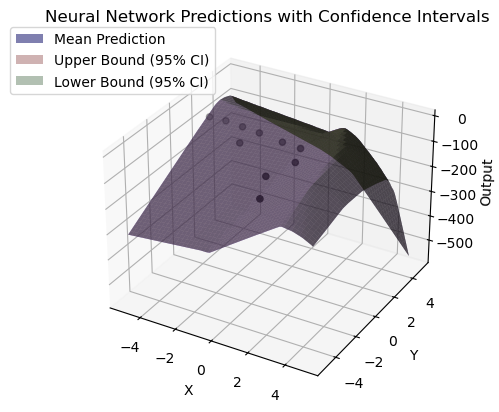

In [28]:
df_sim, df_new = perform_iteration(df_sim, df)


Best hyperparameters:
num_layers: 2
num_units: 156
learning_rate: 0.06160980555339953
dropout_rate: 0.0
batch_size: 150
epochs: 170
Epoch 1/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step - loss: 30248.3418
Epoch 2/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 27476.8145
Epoch 3/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 20822.7129
Epoch 4/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11257.2334
Epoch 5/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 12415.7891
Epoch 6/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 12710.1484
Epoch 7/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8183.3413
Epoch 8/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7695.5386
Epoch 9/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8951.0303
Epoch 10/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9386.6807
Epoch 11/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8635.3076
Epoch 12/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7326.0244
Epoch 13/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

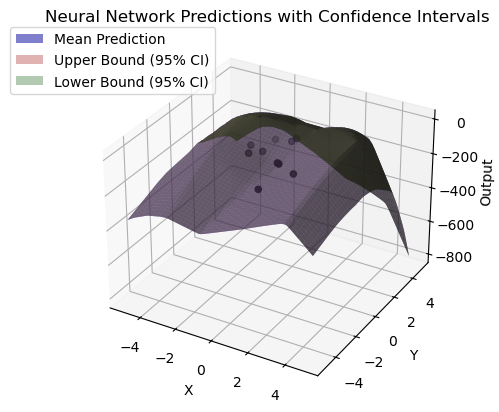

          x         y           z        a         b       sim_z      diff
7 -0.774748  1.674293 -100.944794  4.32433 -3.069244 -100.935236 -0.009558
8  1.591319 -0.759568 -108.455382  4.32433 -3.069244 -108.486785  0.031403
2  0.327715  1.313795 -116.150558  4.32433 -3.069244 -116.213055  0.062497
0  0.847225  0.866763 -117.876051  4.32433 -3.069244 -117.791820 -0.084231
1  1.139536 -1.346325 -138.379410  4.32433 -3.069244 -138.466058  0.086648
           x         y           z        a         b       sim_z      diff
0  -0.829780 -4.076614 -284.253932  4.32433 -3.069244 -282.256649 -1.997283
1   2.203245 -3.137398 -111.669530  4.32433 -3.069244 -113.354470  1.684940
2  -4.998856 -1.544393 -247.301416  4.32433 -3.069244 -242.011988 -5.289428
3  -1.976674 -1.032325 -128.722651  4.32433 -3.069244 -126.540507 -2.182144
4  -3.532441  0.388167 -111.174208  4.32433 -3.069244 -107.847611 -3.326597
..       ...       ...         ...      ...       ...         ...       ...
60 -0.647771  0.22

In [29]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.04662908769092459
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step - loss: 28592.4258
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 28072.5312
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 27341.3008
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 26165.5996
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 24429.9551
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 22071.5273
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19124.2207
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 15757.7383
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 12365.2109
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9704.3086
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8887.4160
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 10268.0918
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

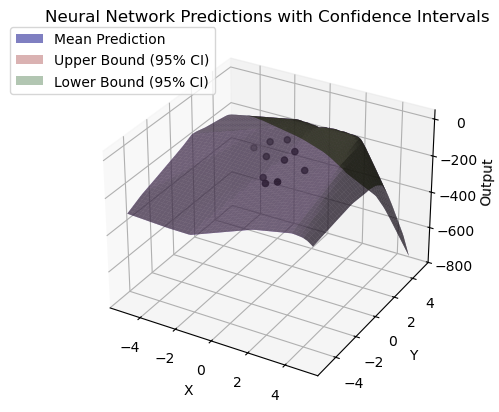

          x         y           z        a         b       sim_z      diff
9 -1.916700  1.561601  -75.311182  4.32433 -3.069244  -75.355378  0.044197
6  1.767206  0.016075  -89.125625  4.32433 -3.069244  -89.113014 -0.012611
0  1.260234 -0.038014 -122.317057  4.32433 -3.069244 -122.185967 -0.131089
4  1.415065 -1.940793 -122.811994  4.32433 -3.069244 -123.001683  0.189688
1  0.147148  1.202750 -124.733554  4.32433 -3.069244 -124.782573  0.049020


In [30]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)

In [31]:
df_new

,x,y,z,a,b,sim_z,diff
9,-1.916700,1.561601,-75.311182,4.32433,-3.069244,-75.355378,0.044197
6,1.767206,0.016075,-89.125625,4.32433,-3.069244,-89.113014,-0.012611
0,1.260234,-0.038014,-122.317057,4.32433,-3.069244,-122.185967,-0.131089
4,1.415065,-1.940793,-122.811994,4.32433,-3.069244,-123.001683,0.189688
1,0.147148,1.202750,-124.733554,4.32433,-3.069244,-124.782573,0.049020


In [32]:
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-4.076614,-284.253932,4.32433,-3.069244,-282.256649,-1.997283
1,2.203245,-3.137398,-111.669530,4.32433,-3.069244,-113.354470,1.684940
2,-4.998856,-1.544393,-247.301416,4.32433,-3.069244,-242.011988,-5.289428
3,-1.976674,-1.032325,-128.722651,4.32433,-3.069244,-126.540507,-2.182144
4,-3.532441,0.388167,-111.174208,4.32433,-3.069244,-107.847611,-3.326597


In [33]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -2.2221023229230723


In [34]:
df = pd.concat([df, df_new], ignore_index=True)
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-4.076614,-284.253932,4.32433,-3.069244,-282.256649,-1.997283
1,2.203245,-3.137398,-111.669530,4.32433,-3.069244,-113.354470,1.684940
2,-4.998856,-1.544393,-247.301416,4.32433,-3.069244,-242.011988,-5.289428
3,-1.976674,-1.032325,-128.722651,4.32433,-3.069244,-126.540507,-2.182144
4,-3.532441,0.388167,-111.174208,4.32433,-3.069244,-107.847611,-3.326597
5,-1.916700,1.561601,-75.311182,4.32433,-3.069244,-75.355378,0.044197
6,1.767206,0.016075,-89.125625,4.32433,-3.069244,-89.113014,-0.012611
7,1.260234,-0.038014,-122.317057,4.32433,-3.069244,-122.185967,-0.131089
8,1.415065,-1.940793,-122.811994,4.32433,-3.069244,-123.001683,0.189688
9,0.147148,1.202750,-124.733554,4.32433,-3.069244,-124.782573,0.049020


In [35]:
df = df.iloc[:, :-4]
df

,x,y,z
0,-0.829780,-4.076614,-284.253932
1,2.203245,-3.137398,-111.669530
2,-4.998856,-1.544393,-247.301416
3,-1.976674,-1.032325,-128.722651
4,-3.532441,0.388167,-111.174208
5,-1.916700,1.561601,-75.311182
6,1.767206,0.016075,-89.125625
7,1.260234,-0.038014,-122.317057
8,1.415065,-1.940793,-122.811994
9,0.147148,1.202750,-124.733554


In [36]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)



[ 4.36702806 -2.94644284]


In [37]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 3.0, "Y": 2.0, "Z": benchmark(3.0, 2.0)},
    {"X": -2.805, "Y": 3.131, "Z": benchmark(-2.805, 3.131)},
    {"X": -3.779, "Y": -3.283, "Z": benchmark(-3.779, -3.283)},
    {"X": 3.584, "Y": -1.848, "Z": benchmark(3.584, -1.848)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

,X,Y,Z
0,3.000,2.000,-0.000000
1,-2.805,3.131,-0.000004
2,-3.779,-3.283,-0.000005
3,3.584,-1.848,-0.000009


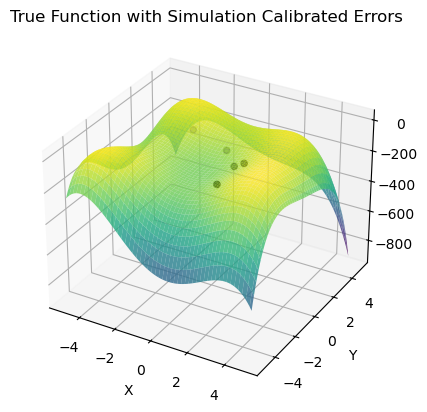

In [38]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_new["x"], df_new["y"], df_new["sim_z"], color='black', marker='o', label='Next Sampling Points')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)



# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [39]:
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-4.076614,-284.253932,4.367028,-2.946443,-284.189317,-0.064615
1,2.203245,-3.137398,-111.669530,4.367028,-2.946443,-111.883375,0.213845
2,-4.998856,-1.544393,-247.301416,4.367028,-2.946443,-246.968163,-0.333254
3,-1.976674,-1.032325,-128.722651,4.367028,-2.946443,-128.486903,-0.235748
4,-3.532441,0.388167,-111.174208,4.367028,-2.946443,-111.231325,0.057117
5,-1.916700,1.561601,-75.311182,4.367028,-2.946443,-75.241028,-0.070154
6,1.767206,0.016075,-89.125625,4.367028,-2.946443,-89.157802,0.032177
7,1.260234,-0.038014,-122.317057,4.367028,-2.946443,-122.208575,-0.108482
8,1.415065,-1.940793,-122.811994,4.367028,-2.946443,-123.034221,0.222226
9,0.147148,1.202750,-124.733554,4.367028,-2.946443,-124.757691,0.024137


In [40]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -0.02627495550195249


In [41]:
# New DataFrame with the first 5 data points
df_original = df.iloc[:5]

print(df_original)

          x         y           z         a         b       sim_z      diff
0 -0.829780 -4.076614 -284.253932  4.367028 -2.946443 -284.189317 -0.064615
1  2.203245 -3.137398 -111.669530  4.367028 -2.946443 -111.883375  0.213845
2 -4.998856 -1.544393 -247.301416  4.367028 -2.946443 -246.968163 -0.333254
3 -1.976674 -1.032325 -128.722651  4.367028 -2.946443 -128.486903 -0.235748
4 -3.532441  0.388167 -111.174208  4.367028 -2.946443 -111.231325  0.057117


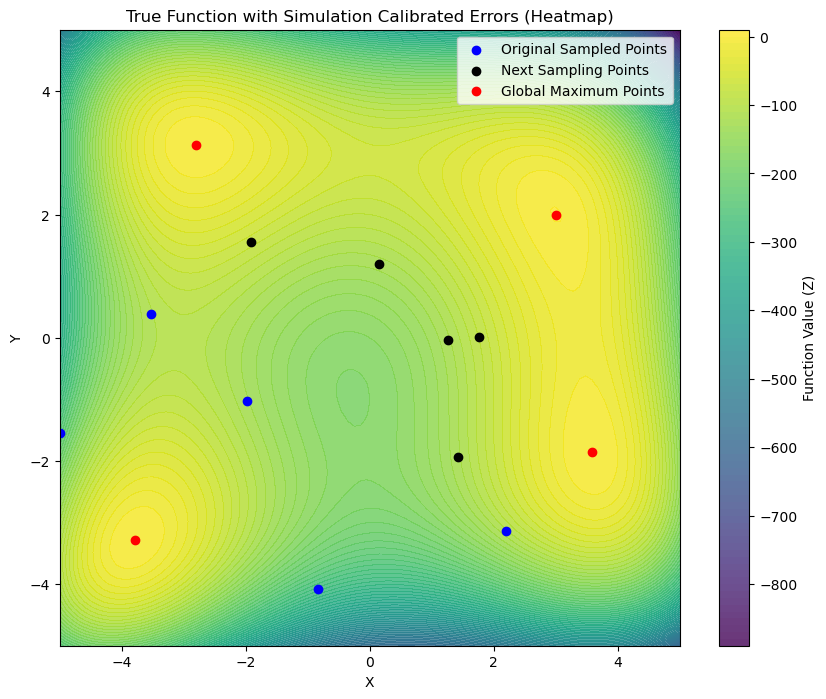

In [42]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [45]:
df_new2 = pd.DataFrame

df_sim = df.copy()

Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.007062194503404528
dropout_rate: 0.5
batch_size: 23
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step - loss: 24184.0449
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 24150.6992
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 24011.4609
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23943.7793
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23863.0586
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 23801.9316
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23733.0918
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23663.2520
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23377.4395
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 23339.6484
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 22963.9590
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 23075.6992
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━

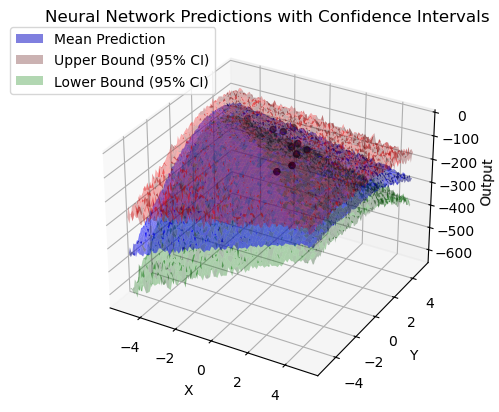

In [47]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step - loss: 17838.2363
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 16852.3730
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 14462.0283
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10054.6465
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4508.5825
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2103.3035
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7005.7212
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4973.0874
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1990.5121
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1375.5659
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2173.4512
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2970.5449
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 31

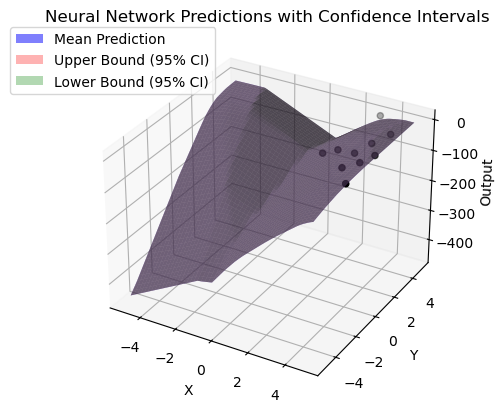

In [48]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 5
num_units: 200
learning_rate: 0.013991873088283858
dropout_rate: 0.0
batch_size: 150
epochs: 181
Epoch 1/181
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 22139.5371
Epoch 2/181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 20074.9941
Epoch 3/181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7824.9575
Epoch 4/181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 73190.2500
Epoch 5/181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4109.9014
Epoch 6/181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 12473.5195
Epoch 7/181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 17951.8535
Epoch 8/181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 20079.8926
Epoch 9/181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 20856.2012
Epoch 10/181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 21081.0332
Epoch 11/181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 21008.2227
Epoch 12/181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 20679.2480
Epoch 13/181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

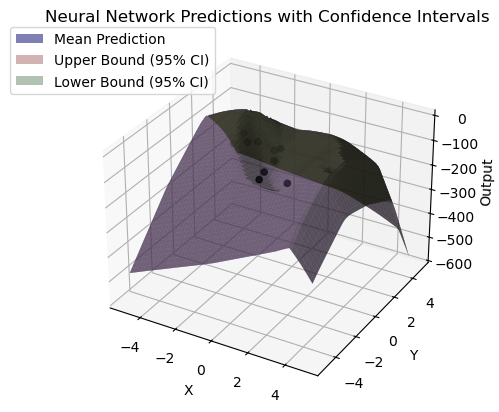

In [49]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 200
learning_rate: 0.01830421450329096
dropout_rate: 0.0
batch_size: 20
epochs: 50
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 13771.9502
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23152.4609 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22762.1895 
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18962.0586 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12214.4971 
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7216.8521 
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9672.6758 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4504.7686 
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4177.9888 
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5170.0249 
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3585.6169 
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4267.2134 
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4

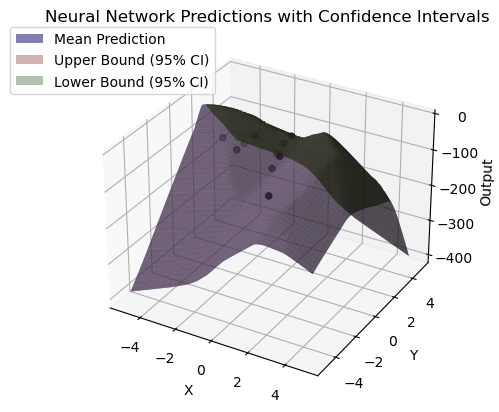

In [50]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 6
num_units: 50
learning_rate: 0.01547076094691046
dropout_rate: 0.0
batch_size: 20
epochs: 132
Epoch 1/132
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 21661.5117
Epoch 2/132
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18241.6680 
Epoch 3/132
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8881.1562 
Epoch 4/132
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5948.5312 
Epoch 5/132
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7955.2915 
Epoch 6/132
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6310.8052 
Epoch 7/132
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5952.0620 
Epoch 8/132
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3920.2273 
Epoch 9/132
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4233.0337 
Epoch 10/132
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2857.3604 
Epoch 11/132
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3196.4734 
Epoch 12/132
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3311.2861 
Epoch 13/132
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

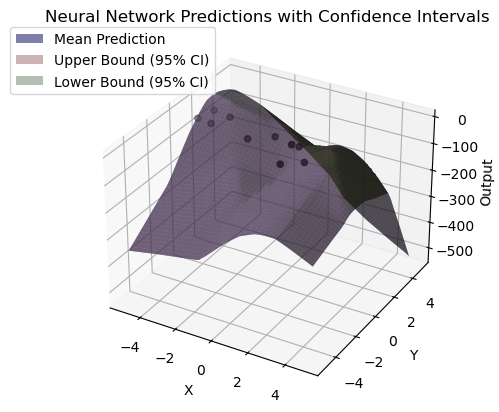

In [51]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 7
num_units: 85
learning_rate: 0.003213501094924151
dropout_rate: 0.0
batch_size: 150
epochs: 134
Epoch 1/134
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 20747.3184
Epoch 2/134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 20692.7754
Epoch 3/134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 20593.2422
Epoch 4/134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 20416.9180
Epoch 5/134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 20118.4297
Epoch 6/134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 19629.7383
Epoch 7/134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 18852.6699
Epoch 8/134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 17644.0762
Epoch 9/134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 15827.9971
Epoch 10/134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 13232.3662
Epoch 11/134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9815.6592
Epoch 12/134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6147.7905
Epoch 13/134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

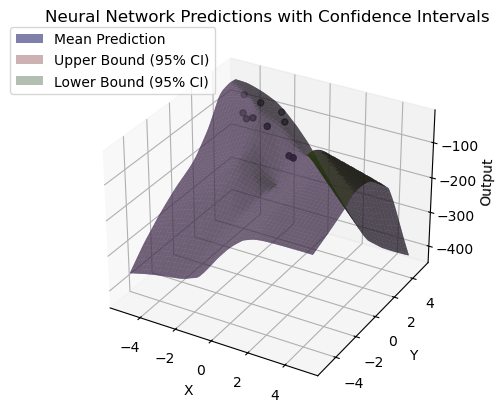

In [52]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 5
num_units: 50
learning_rate: 0.037794490548373985
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 17576.8848
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6686.3281 
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3980.8528 
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3254.2822 
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3026.9236 
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3706.5752 
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4596.5811 
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3792.9072 
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2332.6760 
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1987.0239 
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2241.9568 
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2628.8921 
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

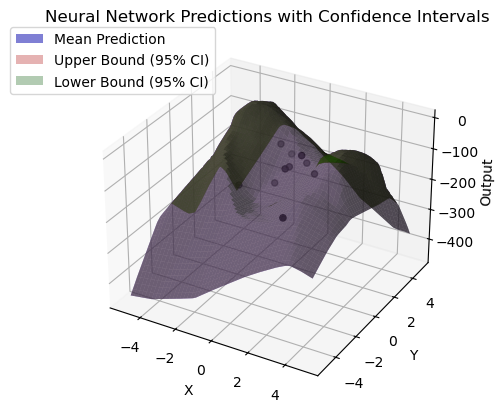

In [53]:
df_sim, df_new2 = perform_iteration(df_sim, df)

In [54]:
df_new2

,x,y,z,a,b,sim_z,diff
6,1.872315,0.795955,-65.035570,4.367028,-2.946443,-64.921414,-0.114156
4,1.282066,1.096005,-88.614013,4.367028,-2.946443,-88.510400,-0.103614
9,1.974166,-2.405797,-91.052600,4.367028,-2.946443,-91.015751,-0.036848
0,1.643548,-0.065654,-98.635558,4.367028,-2.946443,-98.521160,-0.114398
5,0.079114,1.758454,-99.991086,4.367028,-2.946443,-99.903910,-0.087176


In [55]:
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-4.076614,-284.253932,4.367028,-2.946443,-284.189317,-0.064615
1,2.203245,-3.137398,-111.669530,4.367028,-2.946443,-111.883375,0.213845
2,-4.998856,-1.544393,-247.301416,4.367028,-2.946443,-246.968163,-0.333254
3,-1.976674,-1.032325,-128.722651,4.367028,-2.946443,-128.486903,-0.235748
4,-3.532441,0.388167,-111.174208,4.367028,-2.946443,-111.231325,0.057117
5,-1.916700,1.561601,-75.311182,4.367028,-2.946443,-75.241028,-0.070154
6,1.767206,0.016075,-89.125625,4.367028,-2.946443,-89.157802,0.032177
7,1.260234,-0.038014,-122.317057,4.367028,-2.946443,-122.208575,-0.108482
8,1.415065,-1.940793,-122.811994,4.367028,-2.946443,-123.034221,0.222226
9,0.147148,1.202750,-124.733554,4.367028,-2.946443,-124.757691,0.024137


In [56]:
df = pd.concat([df, df_new2], ignore_index=True)
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-4.076614,-284.253932,4.367028,-2.946443,-284.189317,-0.064615
1,2.203245,-3.137398,-111.669530,4.367028,-2.946443,-111.883375,0.213845
2,-4.998856,-1.544393,-247.301416,4.367028,-2.946443,-246.968163,-0.333254
3,-1.976674,-1.032325,-128.722651,4.367028,-2.946443,-128.486903,-0.235748
4,-3.532441,0.388167,-111.174208,4.367028,-2.946443,-111.231325,0.057117
5,-1.916700,1.561601,-75.311182,4.367028,-2.946443,-75.241028,-0.070154
6,1.767206,0.016075,-89.125625,4.367028,-2.946443,-89.157802,0.032177
7,1.260234,-0.038014,-122.317057,4.367028,-2.946443,-122.208575,-0.108482
8,1.415065,-1.940793,-122.811994,4.367028,-2.946443,-123.034221,0.222226
9,0.147148,1.202750,-124.733554,4.367028,-2.946443,-124.757691,0.024137


In [57]:
df = df.iloc[:, :-4]
df

,x,y,z
0,-0.829780,-4.076614,-284.253932
1,2.203245,-3.137398,-111.669530
2,-4.998856,-1.544393,-247.301416
3,-1.976674,-1.032325,-128.722651
4,-3.532441,0.388167,-111.174208
5,-1.916700,1.561601,-75.311182
6,1.767206,0.016075,-89.125625
7,1.260234,-0.038014,-122.317057
8,1.415065,-1.940793,-122.811994
9,0.147148,1.202750,-124.733554


In [58]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.26213596 -3.00210854]


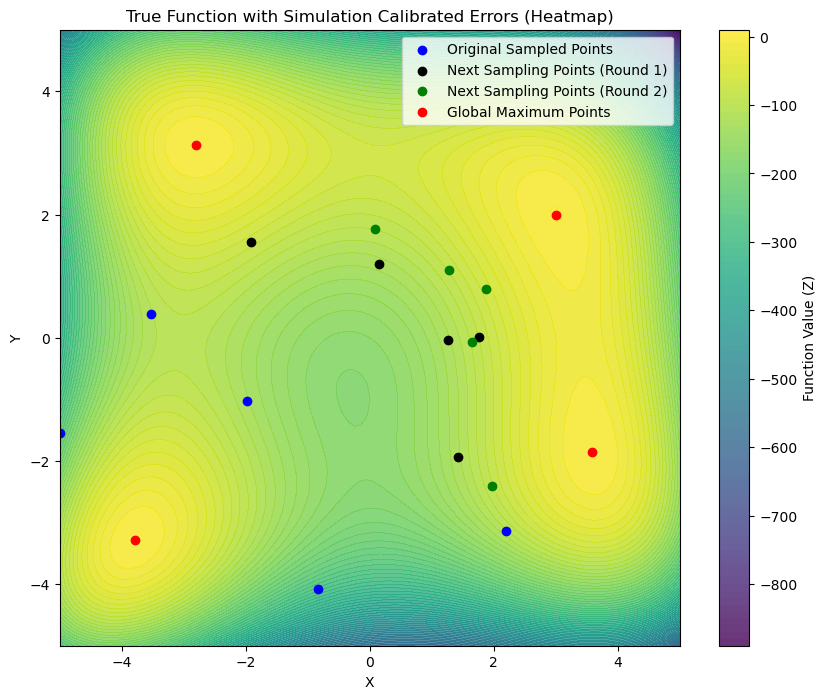

In [59]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()